This notebook demonstrates the use of our linear approximation for sensitivity with respect to the Dirichlet process $\alpha$ parameter

In [1]:
import autograd
from autograd import numpy as np
from autograd import scipy as sp

from numpy.polynomial.hermite import hermgauss

np.random.seed(453453)

import paragami

# BNP sensitivity libraries
import sys

import bnpgmm_runjingdev.gmm_clustering_lib as gmm_lib
import bnpgmm_runjingdev.utils_lib as utils_lib
import bnpgmm_runjingdev.gmm_cavi_lib as cavi_lib

import bnpmodeling_runjingdev.modeling_lib as modeling_lib 
import bnpmodeling_runjingdev.cluster_quantities_lib as cluster_lib
import bnpmodeling_runjingdev.optimization_lib as optimization_lib

import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.cm as cm

from sklearn.decomposition import PCA

from copy import deepcopy

import vittles

import time 

import json 

/home/rliu/anaconda3/envs/bnp_sensitivity/lib/python3.8/site-packages/autograd/core.py:290: UserWarning: 
The defvjp method is deprecated. See the update guide and tutorial:
https://github.com/HIPS/autograd/blob/master/docs/updateguide.md
https://github.com/HIPS/autograd/blob/master/docs/tutorial.md
  warnings.warn(deprecation_msg)


# Load data

We load and plot the iris dataset

In [2]:
# load iris data
dataset_name = 'iris'
features, iris_species = utils_lib.load_data()
dim = features.shape[1]
n_obs = len(iris_species)    

Text(0, 0.5, 'PC2')

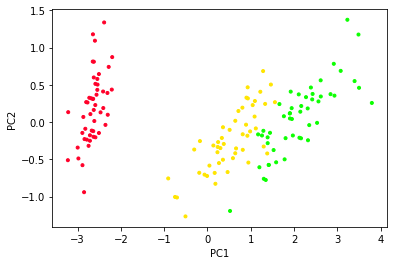

In [3]:
# run PCA
pca_fit = PCA()
pca_fit.fit(features)
pc_features = pca_fit.transform(features)

# plot
cmap = cm.get_cmap(name='gist_rainbow')
colors1 = [cmap(k * 50) for k in range(30)]

fig1 = plt.figure(1)
fig = fig1.add_subplot(111)
utils_lib.plot_clusters(pc_features[:, 0], pc_features[:, 1], iris_species, colors1, fig)
fig.set_xlabel('PC1')
fig.set_ylabel('PC2')


# Set up model

### Prior parameters

In [5]:
# Get priors
prior_params_dict, prior_params_paragami = gmm_lib.get_default_prior_params(dim)
prior_params_dict['alpha'] = np.array([3.0])
print(prior_params_dict)

{'alpha': array([3.]), 'prior_centroid_mean': array([0.]), 'prior_lambda': array([1.]), 'prior_wishart_df': array([10.]), 'prior_wishart_rate': array([[1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.]])}


### Variational parameters

In [6]:
# number of clusters in variational distribution 
k_approx = 30

In [7]:
# Gauss-Hermite points for integrating logitnormal stick-breaking prior
gh_deg = 8
gh_loc, gh_weights = hermgauss(gh_deg)

In [8]:
# get vb parameters
vb_params_dict, vb_params_paragami = gmm_lib.get_vb_params_paragami_object(dim, k_approx)

In [9]:
# the objective 
gmm_lib.get_kl(features, vb_params_dict, prior_params_dict, gh_loc, gh_weights)

1731.7713604176683

# Optimize the KL objective

### Initialize with k-means

In [10]:
# run a kmeans init
n_kmeans_init = 10
init_vb_free_params, init_vb_params_dict, init_ez = \
    utils_lib.cluster_and_get_k_means_inits(features, vb_params_paragami, 
                                                n_kmeans_init = n_kmeans_init, 
                                                seed = 34545)
                                                
print('initial kl: ')
print(gmm_lib.get_kl(features, init_vb_params_dict, prior_params_dict, gh_loc, gh_weights))

initial kl: 
8534.610143468191


In [11]:
def plot_results_from_vb_params_dict(pca_fit, vb_params_dict, e_z, fig): 
    # we plot in PCA space
    bnp_centroids_pc, bnp_cluster_covs_pc = \
        utils_lib.transform_params_to_pc_space(pca_fit, vb_params_dict['cluster_params']['centroids'], 
                                               np.linalg.inv(vb_params_dict['cluster_params']['cluster_info']))
    
    bnp_clusters = np.argmax(e_z, axis = 1)
    
    cmap = cm.get_cmap(name='gist_rainbow')
    colors1 = [cmap(k * 50) for k in range(30)]

    utils_lib.plot_clusters(pc_features[:, 0], pc_features[:, 1], bnp_clusters, \
                  colors1, fig, \
                  centroids = bnp_centroids_pc[:, np.unique(bnp_clusters)], 
                cov = bnp_cluster_covs_pc[np.unique(bnp_clusters)])


Text(0, 0.5, 'PC2')

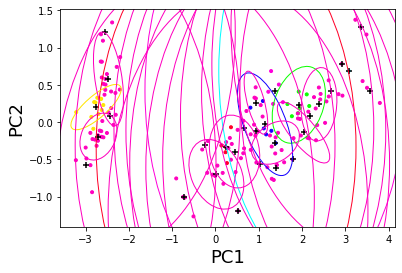

In [12]:
fig1 = plt.figure(1)
fig = fig1.add_subplot(111)

plot_results_from_vb_params_dict(pca_fit, init_vb_params_dict, init_ez, fig)
fig.set_xlabel('PC1', fontsize = 18)
fig.set_ylabel('PC2', fontsize = 18)


In [13]:
vb_params_dict = deepcopy(init_vb_params_dict)

## optimize

In [14]:
run_newton = False

In [15]:
# get loss as a function of vb parameters
get_vb_params_loss = paragami.FlattenFunctionInput(
                                original_fun=gmm_lib.get_kl, 
                                patterns = vb_params_paragami,
                                free = True,
                                argnums = 1)

get_loss = lambda x : get_vb_params_loss(features, x, prior_params_dict, gh_loc, gh_weights)


done. num iterations = 73
stick_time: 0.436sec
cluster_time: 0.039sec
e_z_time: 0.103sec
**TOTAL time: 0.752sec**


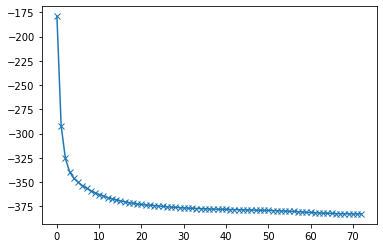

In [16]:
if run_newton: 
    vb_opt = optimization_lib.optimize_full(get_loss, deepcopy(init_vb_free_params),
                    bfgs_max_iter = 500, netwon_max_iter = 50,
                    max_precondition_iter = 10,
                    gtol=1e-8, ftol=1e-8, xtol=1e-8)
    
    vb_opt_dict = vb_params_paragami.fold(vb_opt, free = True)
    e_z_opt = gmm_lib.get_optimal_z_from_vb_params_dict(features, vb_opt_dict, gh_loc, gh_weights)
    
else: 
    vb_opt_dict, e_z_opt, kl_loss = cavi_lib.run_cavi(features, vb_params_dict,
                                            vb_params_paragami, prior_params_dict,
                                            gh_loc, gh_weights,
                                           debug = False)
    vb_opt = vb_params_paragami.flatten(vb_opt_dict, free = True)

    plt.plot(kl_loss, '-x')

In [17]:
continue_with_newton = False

if continue_with_newton: 
    
    vb_opt2 = optimization_lib.optimize_full(get_loss, 
                    deepcopy(vb_opt),
                    bfgs_max_iter = 500, netwon_max_iter = 50,
                    max_precondition_iter = 10,
                    gtol=1e-8, ftol=1e-8, xtol=1e-8)
    
    print('\nlinf diff in vb_params: ', np.abs(vb_opt2 - vb_opt).max())
    
    vb_opt = deepcopy(vb_opt2)
    pt_dict = vb_params_paragami.fold(vb_opt, free = True)
    e_z_opt = gmm_lib.get_optimal_z_from_vb_params_dict(features, vb_opt_dict, gh_loc, gh_weights)
    

### Check optimum

In [18]:
get_prior_vb_loss = paragami.FlattenFunctionInput(original_fun=gmm_lib.get_kl, 
                                    patterns = [vb_params_paragami, prior_params_paragami],
                                    free = True,
                                    argnums = [1, 2])

objective_fun = lambda x, y: get_prior_vb_loss(features, x, y, gh_loc, gh_weights)

In [19]:
# get hessian 
t0 = time.time()
get_hess = autograd.hessian(objective_fun, argnum = 0)
hessian_at_opt = get_hess(vb_opt, prior_params_paragami.flatten(prior_params_dict, free = True))
print('hessian time: {}sec'.format(np.round(time.time() - t0, 3)))

hess_solver = vittles.solver_lib.get_cholesky_solver(hessian_at_opt)

hessian time: 15.145sec


In [20]:
# gradient 
get_objective_grad = autograd.jacobian(objective_fun, argnum = 0)

In [21]:
optimum_checker = vittles.bivariate_sensitivity_lib.OptimumChecker(
                                                estimating_equation = get_objective_grad, 
                                                solver = hess_solver, 
                                                input_base = vb_opt, 
                                                hyper_base = prior_params_paragami.flatten(prior_params_dict, 
                                                                                           free = True))

/home/rliu/anaconda3/envs/bnp_sensitivity/lib/python3.8/site-packages/vittles/bivariate_sensitivity_lib.py:32: UserWarning: The CrossSensitivity class is very experimental and untested.
  warnings.warn(


In [22]:
newton_step = optimum_checker.get_newton_step()

In [23]:
np.abs(newton_step).max()

0.22898131893160875

In [24]:
# examine the size of the newton step

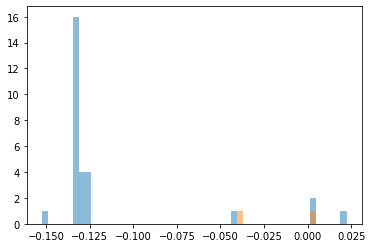

In [25]:
bins = plt.hist(newton_step[utils_lib.get_param_indices('stick_propn_mean', vb_params_dict, vb_params_paragami)],
         alpha = 0.5, bins = 50)
plt.hist(newton_step[utils_lib.get_param_indices('stick_propn_info', vb_params_dict, vb_params_paragami)],
         alpha = 0.5, bins=bins[1]);

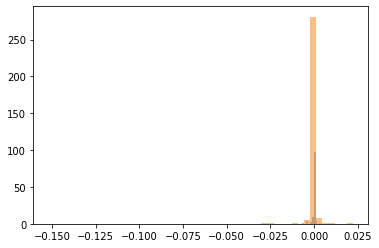

In [26]:
predictivebins= plt.hist(newton_step[utils_lib.get_param_indices('centroids', vb_params_dict, vb_params_paragami)],
         alpha = 0.5)
plt.hist(newton_step[utils_lib.get_param_indices('cluster_info', vb_params_dict, vb_params_paragami)],
         alpha = 0.5, bins=bins[1]);



### Check results

Text(0, 0.5, 'PC2')

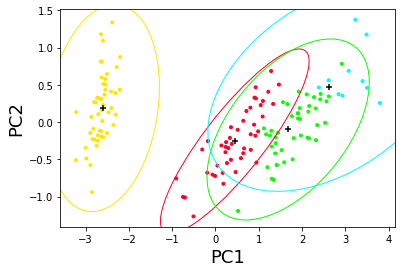

In [27]:
# optimization results
fig1 = plt.figure(1)
fig = fig1.add_subplot(111)

plot_results_from_vb_params_dict(pca_fit, vb_opt_dict, e_z_opt, fig)
fig.set_xlabel('PC1', fontsize = 18)
fig.set_ylabel('PC2', fontsize = 18)


# Parametric sensitivity

### Get the hyper parameter sensitivity object

In [28]:
vb_sens = \
    vittles.HyperparameterSensitivityLinearApproximation(
        objective_fun = objective_fun, 
        opt_par_value = vb_opt, 
        hyper_par_value = prior_params_paragami.flatten(prior_params_dict, free=True), 
        hessian_at_opt = hessian_at_opt)


### Set new prior

In [29]:
new_alpha = np.array([5.])

prior_params_pert_dict = deepcopy(prior_params_dict)
prior_params_pert_dict['alpha'] = new_alpha


In [30]:
print('initial alpha, ', prior_params_dict['alpha'])
print('perturbed alpha, ', prior_params_pert_dict['alpha'])

initial alpha,  [3.]
perturbed alpha,  [5.]


### get linear response prediction

In [31]:
lr_vb_free_params = \
    vb_sens.predict_opt_par_from_hyper_par(
        prior_params_paragami.flatten(prior_params_pert_dict, free = True))

In [32]:
print('l_inf diff: ', np.max(np.abs(lr_vb_free_params - vb_opt)))

l_inf diff:  0.5994591195976313


### re-optimize

In [33]:
new_init_dict = deepcopy(vb_opt_dict)
# new_init_dict = deepcopy(init_vb_params_dict)
new_init_free = vb_params_paragami.flatten(new_init_dict, free = True)

In [34]:
run_newton = False

In [35]:
if run_newton :
    # set up new objective, with the prior changed
    get_pert_loss = lambda x : get_vb_params_loss(features, x, prior_params_pert_dict, gh_loc, gh_weights)

    # Run newton
    vb_opt_pert = optimization_lib.optimize_full(get_pert_loss, deepcopy(new_init_free),
                        bfgs_max_iter = 500, netwon_max_iter = 50,
                        max_precondition_iter = 10,
                        gtol=1e-8, ftol=1e-8, xtol=1e-8)
    
else: 
    vb_pert_dict, e_z_pert, kl_loss = cavi_lib.run_cavi(features, deepcopy(new_init_dict),
                                            vb_params_paragami, prior_params_pert_dict,
                                            gh_loc, gh_weights,
                                           debug = True)
    
    vb_opt_pert = vb_params_paragami.flatten(vb_pert_dict, free = True)

done. num iterations = 19
stick_time: 0.108sec
cluster_time: 0.062sec
e_z_time: 0.032sec
**TOTAL time: 0.4sec**


### Compare linear response with refitting

In [36]:
def print_diff_plot(lr_vb_free_params, vb_opt_pert, vb_opt): 
    plt.plot(lr_vb_free_params - vb_opt, 
             vb_opt_pert - vb_opt, 
             '+', color = 'red')

    plt.plot(lr_vb_free_params - vb_opt, 
            lr_vb_free_params - vb_opt, 
             '-', color = 'blue')

    plt.xlabel('lr')
    plt.ylabel('re-optimized')

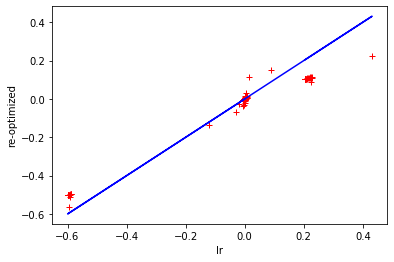

In [37]:
print_diff_plot(lr_vb_free_params, vb_opt_pert, vb_opt)

In [38]:
get_loss(lr_vb_free_params)

-379.6348435584019

In [39]:
get_loss(vb_opt_pert)

-380.75910621398054

# Fit for a range of alpha 

In [40]:
alpha_list = np.arange(1, 15)

In [42]:
def refit_with_alpha(alpha, vb_opt, new_init_dict, run_newton):
    # sets new alpha, returns new vb optimum
    
    # set new prior
    new_alpha = np.array([alpha])

    prior_params_pert_dict = deepcopy(prior_params_dict)
    prior_params_pert_dict['alpha'] = new_alpha
    
    if run_newton:
                
        # set up new objective, with the prior changed
        get_pert_loss = lambda x : get_vb_params_loss(features, x, prior_params_pert_dict, gh_loc, gh_weights)

        # Run newton
        vb_opt_pert = optimization_lib.optimize_full(get_pert_loss, 
                            vb_params_paragami.flatten(deepcopy(new_init_dict), free = True),
                            bfgs_max_iter = 500, netwon_max_iter = 50,
                            max_precondition_iter = 10,
                            gtol=1e-8, ftol=1e-8, xtol=1e-8)

    else: 
        vb_pert_dict, e_z_pert, kl_loss = cavi_lib.run_cavi(features, deepcopy(new_init_dict),
                                                vb_params_paragami, prior_params_pert_dict,
                                                gh_loc, gh_weights,
                                               debug = True)

        vb_opt_pert = vb_params_paragami.flatten(vb_pert_dict, free = True)   
        
    return vb_opt_pert

### Re-optimize for range of alphas

In [43]:
print('alphas: ', alpha_list)

alphas:  [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14]


In [44]:
vb_pert_list = []
for alpha in alpha_list: 
    print('\nre-optimzing with alpha = ', alpha)
    
    vb_pert_list.append(refit_with_alpha(alpha, vb_opt, new_init_dict, run_newton))


re-optimzing with alpha =  1
done. num iterations = 26
stick_time: 0.143sec
cluster_time: 0.078sec
e_z_time: 0.035sec
**TOTAL time: 0.513sec**

re-optimzing with alpha =  2
done. num iterations = 22
stick_time: 0.129sec
cluster_time: 0.065sec
e_z_time: 0.033sec
**TOTAL time: 0.457sec**

re-optimzing with alpha =  3
done. num iterations = 4
stick_time: 0.028sec
cluster_time: 0.015sec
e_z_time: 0.007sec
**TOTAL time: 0.098sec**

re-optimzing with alpha =  4
done. num iterations = 17
stick_time: 0.096sec
cluster_time: 0.055sec
e_z_time: 0.025sec
**TOTAL time: 0.355sec**

re-optimzing with alpha =  5
done. num iterations = 19
stick_time: 0.105sec
cluster_time: 0.06sec
e_z_time: 0.029sec
**TOTAL time: 0.389sec**

re-optimzing with alpha =  6
done. num iterations = 15
stick_time: 0.091sec
cluster_time: 0.044sec
e_z_time: 0.023sec
**TOTAL time: 0.309sec**

re-optimzing with alpha =  7
done. num iterations = 33
stick_time: 0.2sec
cluster_time: 0.11sec
e_z_time: 0.047sec
**TOTAL time: 0.714sec

### get linear response prediction for each alpha

In [45]:
lr_list = []

for alpha in alpha_list: 
    
    # set alpha 
    new_alpha = np.array([alpha])
    prior_params_pert_dict = deepcopy(prior_params_dict)
    prior_params_pert_dict['alpha'] = new_alpha
    
    # get linear response
    lr_list.append(vb_sens.predict_opt_par_from_hyper_par(
        prior_params_paragami.flatten(prior_params_pert_dict, free = True)))
    

In [46]:
### Get Newton step correction to linear response
lr_list_corr = []
for i in range(len(lr_list)): 
    correction = optimum_checker.correction(prior_params_paragami.flatten(
                                            prior_params_pert_dict, free = True))
    
    lr_list_corr.append(lr_list[i] + newton_step + correction)
                        

### examine results 

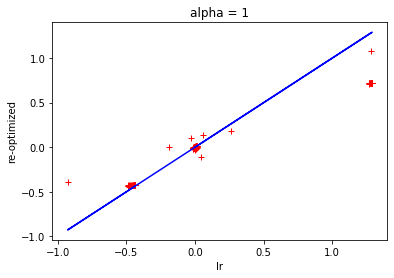

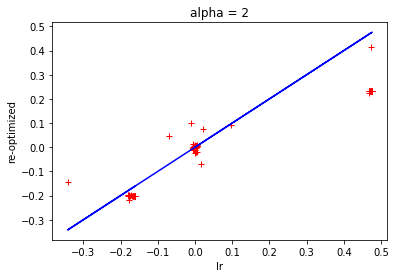

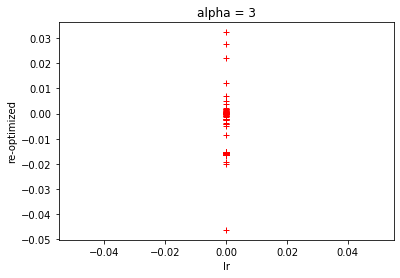

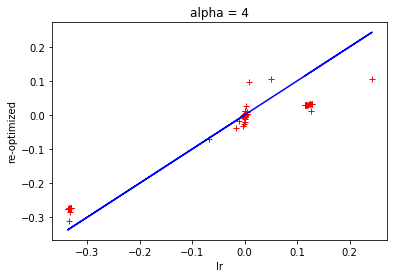

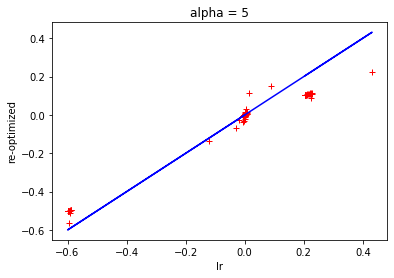

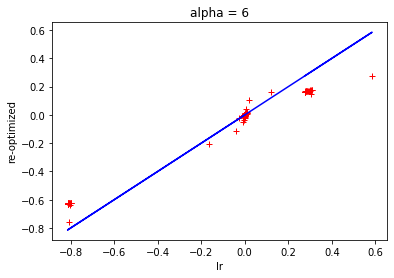

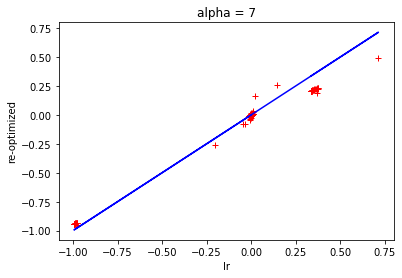

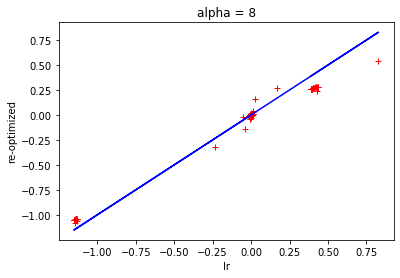

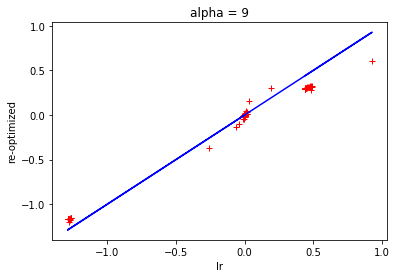

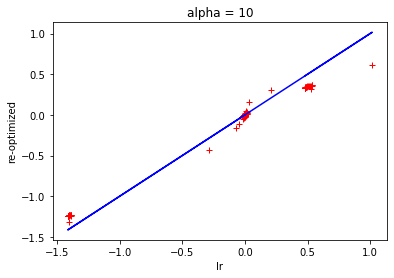

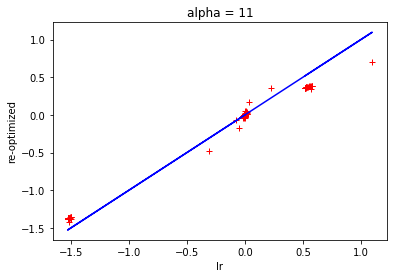

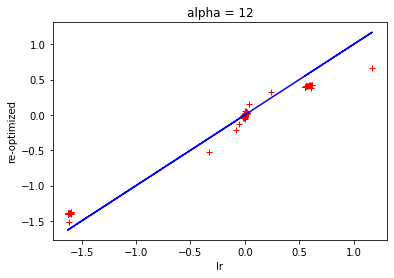

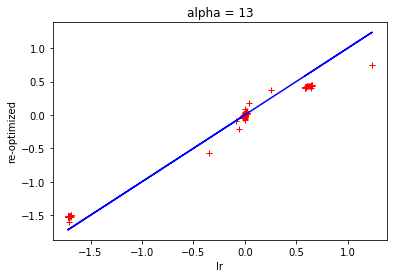

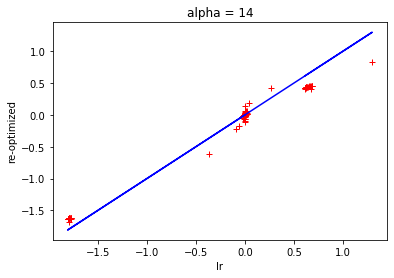

In [47]:
for i in range(len(alpha_list)): 
    plt.figure()
    print_diff_plot(lr_list[i], vb_pert_list[i], vb_opt)
    
    plt.title('alpha = {}'.format(alpha_list[i]))
    
#     opt_dict = vb_params_paragami.fold(vb_opt, free = True)
#     lr_dict = vb_params_paragami.fold(lr_list[i], free = True)
#     pert_dict = vb_params_paragami.fold(vb_pert_list[i], free = True)
    
# #     print_diff_plot(vb_params_paragami['stick_params'].flatten(lr_dict['stick_params'], free = True), 
# #                     vb_params_paragami['stick_params'].flatten(pert_dict['stick_params'], free = True), 
# #                     vb_params_paragami['stick_params'].flatten(opt_dict['stick_params'], free = True))
    
#     print_diff_plot(vb_params_paragami['cluster_params'].flatten(lr_dict['cluster_params'], free = True), 
#                 vb_params_paragami['cluster_params'].flatten(pert_dict['cluster_params'], free = True), 
#                 vb_params_paragami['cluster_params'].flatten(opt_dict['cluster_params'], free = True))



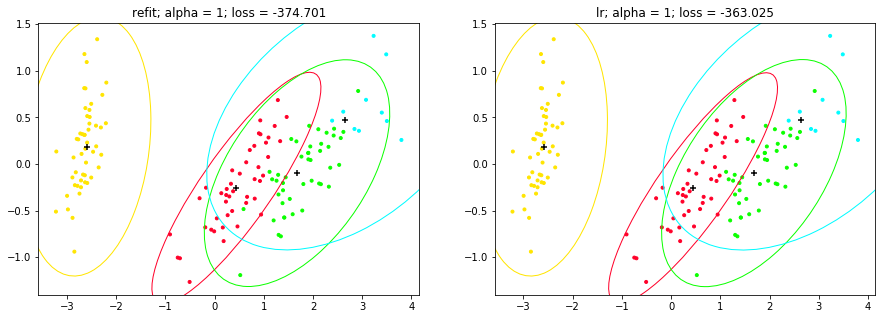

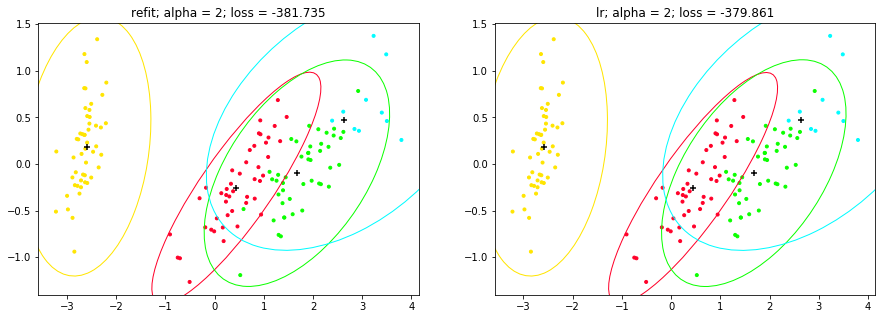

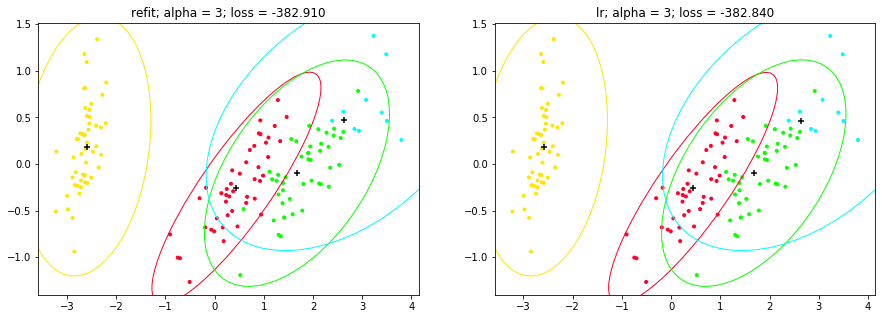

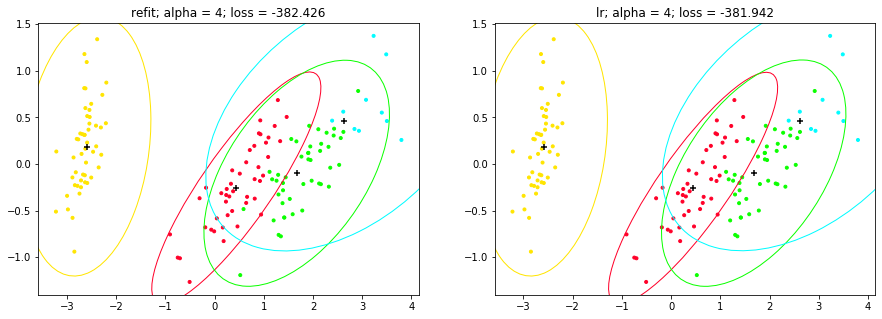

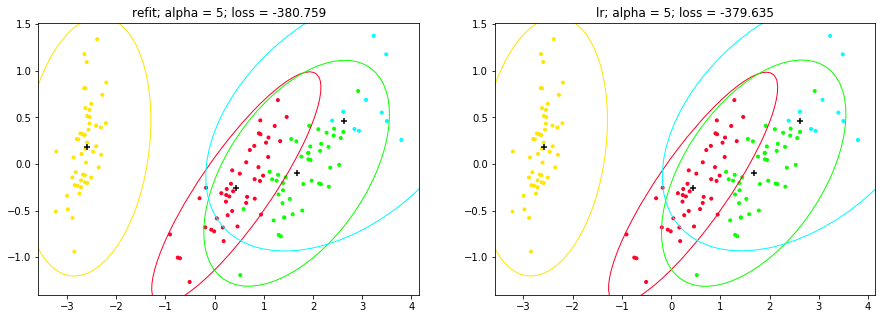

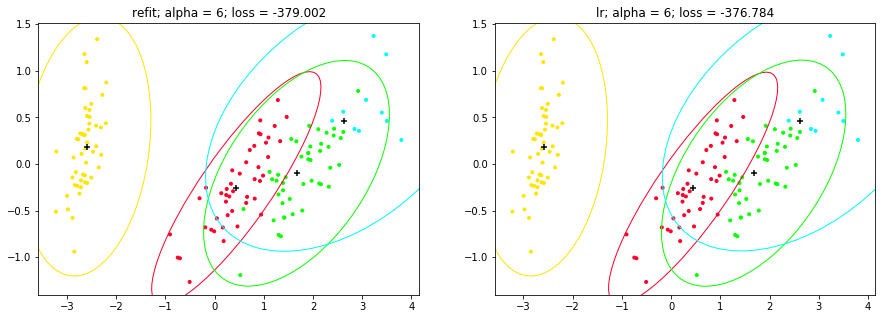

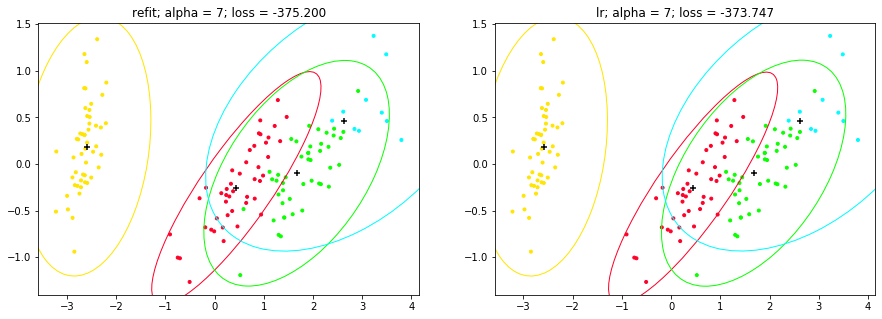

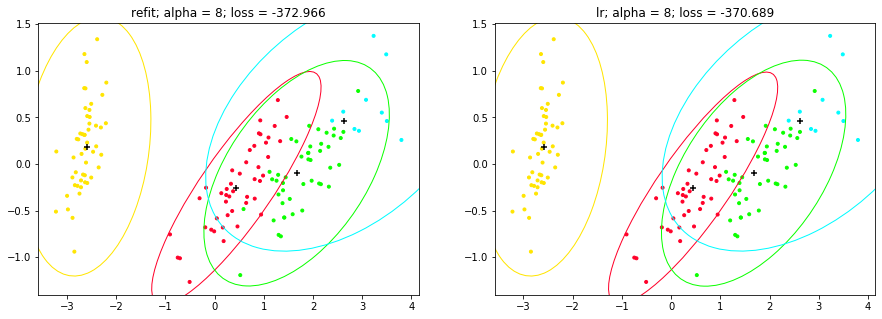

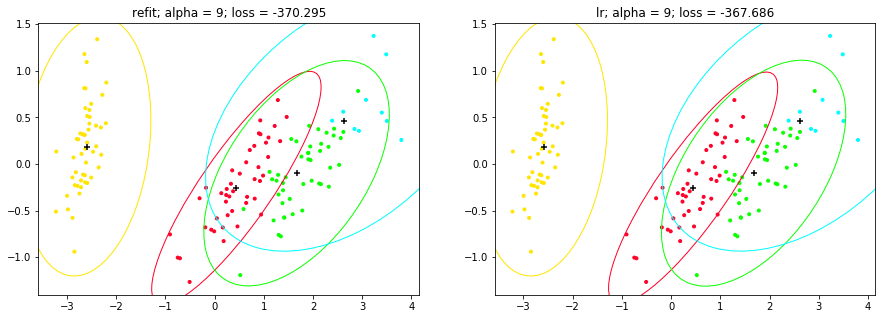

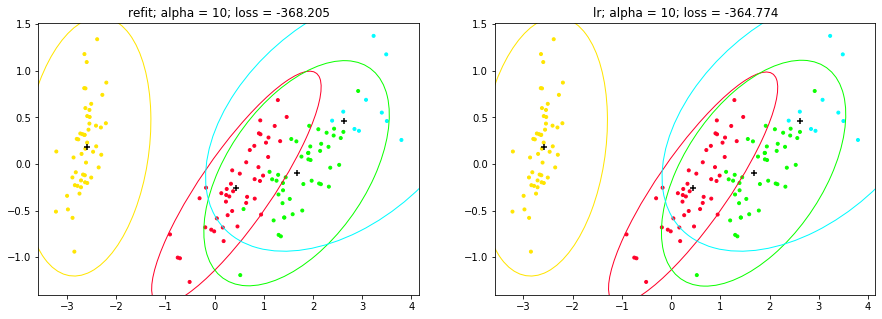

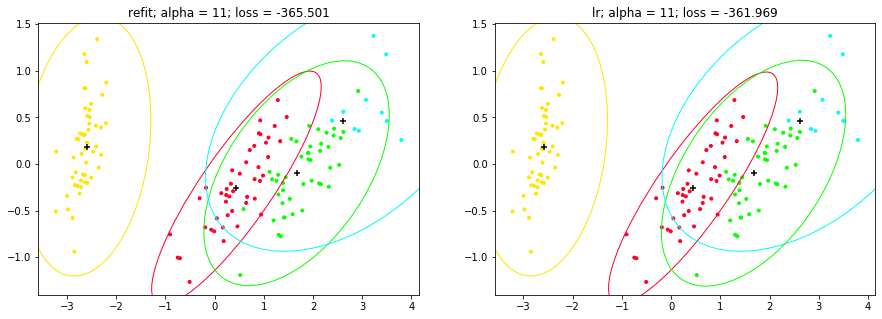

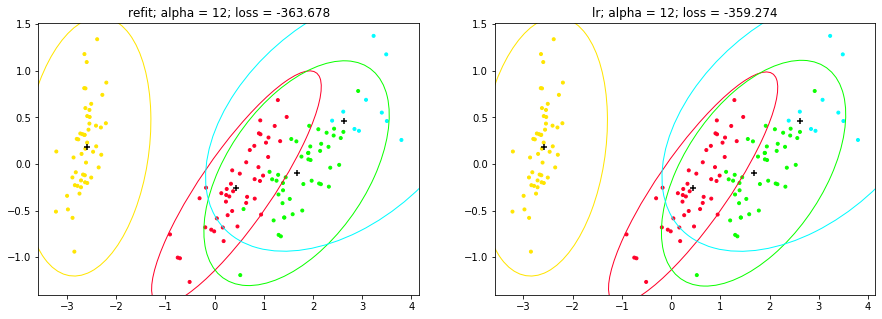

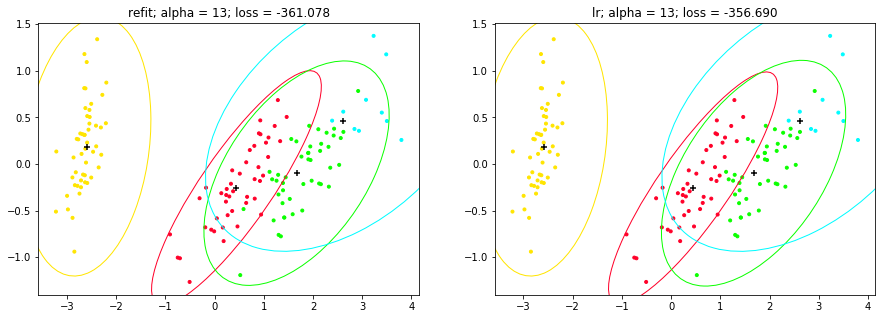

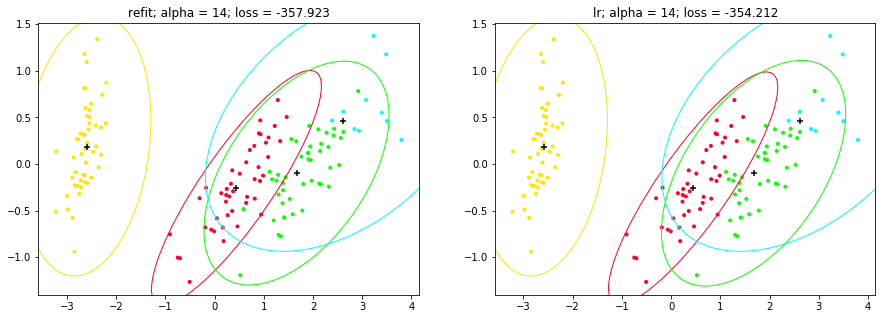

In [48]:
for i in range(len(alpha_list)): 

    fig, axes = plt.subplots(1, 2, figsize = (15, 5))

    lr_dict = vb_params_paragami.fold(lr_list[i], free = True)
    pert_dict = vb_params_paragami.fold(vb_pert_list[i], free = True)

    plot_results_from_vb_params_dict(pca_fit, pert_dict, 
                                     gmm_lib.get_optimal_z_from_vb_params_dict(features, pert_dict,
                                                                                gh_loc, gh_weights), 
                                     axes[0])
    
    plot_results_from_vb_params_dict(pca_fit, lr_dict, 
                                     gmm_lib.get_optimal_z_from_vb_params_dict(features, lr_dict,
                                                                                gh_loc, gh_weights), 
                                     axes[1])
    
    axes[0].set_title('refit; alpha = {}; loss = {:.03f}'.format(alpha_list[i], get_loss(vb_pert_list[i])))
    axes[1].set_title('lr; alpha = {}; loss = {:.03f}'.format(alpha_list[i], get_loss(lr_list[i])))

# Check results on number of clusters

### results on number of in-sample clusters

In [49]:
threshold = 0

lr_e_num_clusters_vec = np.zeros(len(alpha_list))
refit_e_num_clusters_vec = np.zeros(len(alpha_list))

for i in range(len(alpha_list)): 
    # number of clusters as predicted by linear response
    lr_e_num_clusters, _ = gmm_lib.get_e_num_clusters_from_free_par(features, vb_params_paragami, 
                                    lr_list[i],
                                    gh_loc, gh_weights,
                                    threshold = threshold,
                                    n_samples = 100000)
    
    lr_e_num_clusters_vec[i] = lr_e_num_clusters
    
    # number of clusters after refitting 
    refit_e_num_clusters, _ = gmm_lib.get_e_num_clusters_from_free_par(features, vb_params_paragami, 
                                    vb_pert_list[i],
                                    gh_loc, gh_weights,
                                    threshold = threshold,
                                    n_samples = 100000)
    
    refit_e_num_clusters_vec[i] = refit_e_num_clusters
    


In [50]:
# linear response + correction results
lr_corr_e_num_clusters_vec = np.zeros(len(alpha_list))

for i in range(len(alpha_list)): 
    # number of clusters as predicted by linear response
    lr_e_num_clusters, _ = gmm_lib.get_e_num_clusters_from_free_par(features, vb_params_paragami, 
                                    lr_list_corr[i],
                                    gh_loc, gh_weights,
                                    threshold = threshold,
                                    n_samples = 100000)
    
    lr_corr_e_num_clusters_vec[i] = lr_e_num_clusters
        


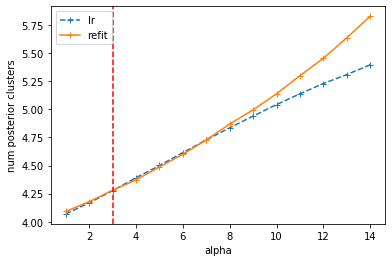

In [54]:
plt.plot(alpha_list, lr_e_num_clusters_vec, '+--')
# plt.plot(alpha_list, lr_corr_e_num_clusters_vec, '+--')

plt.plot(alpha_list, refit_e_num_clusters_vec, '+-')

plt.xlabel('alpha')
plt.ylabel('num posterior clusters')
# plt.legend(('lr', 'lr_corr', 'refit'))
plt.legend(('lr', 'refit'))

plt.axvline(prior_params_dict['alpha'], color = 'red', linestyle = 'dashed')


### Results on posterior predictive clusters

In [78]:
threshold = 0

lr_e_num_pred_clusters_vec = np.zeros(len(alpha_list))
refit_e_num_pred_clusters_vec = np.zeros(len(alpha_list))

for i in range(len(alpha_list)): 
     # number of clusters as predicted by linear response
    lr_e_num_pred_clusters = gmm_lib.get_e_num_pred_clusters_from_vb_free_params(vb_params_paragami, 
                                    lr_list[i],
                                    n_obs = np.shape(features)[0], 
                                    threshold = threshold,
                                    n_samples = 100000)
    
    lr_e_num_pred_clusters_vec[i] = lr_e_num_pred_clusters
    
    # number of clusters after refitting 
    refit_e_num_pred_clusters = gmm_lib.get_e_num_pred_clusters_from_vb_free_params(vb_params_paragami, 
                                    vb_pert_list[i],
                                    n_obs = np.shape(features)[0], 
                                    threshold = threshold,
                                    n_samples = 100000)
    
    refit_e_num_pred_clusters_vec[i] = refit_e_num_pred_clusters
    


In [79]:
# linear response + correction results
lr_corr_e_num_pred_clusters_vec = np.zeros(len(alpha_list))

for i in range(len(alpha_list)): 
    # number of clusters as predicted by linear response
    lr_e_num_clusters = gmm_lib.get_e_num_pred_clusters_from_vb_free_params(vb_params_paragami, 
                                    lr_list_corr[i],
                                    n_obs = np.shape(features)[0], 
                                    threshold = threshold,
                                    n_samples = 100000)
    
    lr_corr_e_num_pred_clusters_vec[i] = lr_e_num_clusters
        


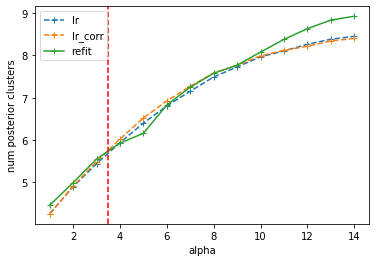

In [80]:
plt.plot(alpha_list, lr_e_num_pred_clusters_vec, '+--')
plt.plot(alpha_list, lr_corr_e_num_pred_clusters_vec, '+--')

plt.plot(alpha_list, refit_e_num_pred_clusters_vec, '+-')

plt.xlabel('alpha')
plt.ylabel('num posterior clusters')
plt.legend(('lr', 'lr_corr', 'refit'))

plt.axvline(prior_params_dict['alpha'], color = 'red', linestyle = 'dashed')
